In [1]:
# make this calculation iterative
# compare with the exact O-U solution
# generalize to 2D
# future work: incorporate Anderson-Mattingly propagator

import sys
sys.path.append("/usr/local/TSG/python")
import TasmanianSG
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

In [25]:
grid = TasmanianSG.TasmanianSparseGrid()
iDim = 1
iLevel = 50

In [26]:
grid.makeGlobalGrid(iDim,0,iLevel,"level","chebyshev",[])
aPoints = grid.getPoints()
aWeights = grid.getQuadratureWeights()
reordering = np.argsort(aPoints[:,0])
aPoints = aPoints[reordering]
aWeights = aWeights[reordering]
print(len(aPoints))

51


In [27]:
np.dot(aWeights,np.power(aPoints,8)) - 2/9

array([ -5.55111512e-17])

In [28]:
theta = 1.0
mu = 0.5
sigma = 0.5
def f(x):
    return theta*(mu-x)

def g(x):
    if np.isscalar(x):
        return sigma
    else:
        return sigma*np.ones(x.shape)
    

In [29]:
ic = 0.1
ft = 1.0
numsteps = 10
h = ft/numsteps
g2ic = np.square(g(ic))

# setting things up to integrate from -scaling to +scaling
scaling = 4.0
xgrid = scaling*aPoints.flatten()
xweights = scaling*aWeights

# define initial condition function
def p(x):
    p = np.exp(-np.square(x - ic - f(ic)*h)/(2.0*g2ic*h))/np.sqrt(2.0*np.pi*g2ic*h)
    return(p)

# define exact solution
def exactpdf(x,t):
    thismu = mu + (ic - mu)*np.exp(-theta*t)
    thissd = sigma*np.sqrt((1.0 - np.exp(-2.0*theta*t))/(2.0*theta))
    return scipy.stats.norm.pdf(x, loc=thismu, scale=thissd)

In [30]:
# check normalization of initial condition
# remember, you need to evaluate on xgrid to do quadrature,
# but you need to evaluate on collocgrid to do collocation
p1 = p(xgrid)
print(np.dot(xweights,p1))

0.999200070406


In [31]:
# direct calculation of p2
p2 = np.zeros(len(aPoints))
for j in np.arange(len(aPoints)):
    x = xgrid[j]
    numer = np.square(xgrid + f(x + xgrid)*h)
    denom = 2.0*np.square(g(x + xgrid))*h
    part1 = np.exp(-numer/denom)/np.sqrt(np.pi*denom)
    part2 = p(x + xgrid)
    p2[j] = np.dot(xweights,part1*part2)
    
print(np.dot(xweights,p2))
print(np.linalg.norm(p1 - exactpdf(xgrid,h)))
print(np.linalg.norm(p2 - exactpdf(xgrid,2*h)))

0.999716174917
0.065852907642
0.101881696373


In [32]:
amat = np.zeros((len(xweights),len(xweights)))
endpt = scaling
collocgrid = np.linspace(-endpt,endpt,len(aWeights))
spacing = (collocgrid[1]-collocgrid[0])
def psi(x):
    # return np.exp(-np.square(x)/2.0)/np.sqrt(2.0*np.pi)
    temp = 1 - np.abs(x)
    temp[temp<0] = 0
    return temp

def phi(x,j):
    return (psi((x - collocgrid[j])/spacing)/spacing).flatten()

print(str(spacing) + "\n")
for j in np.arange(len(aPoints)):
    amat[:,j] = phi(collocgrid.flatten(),j)


0.16



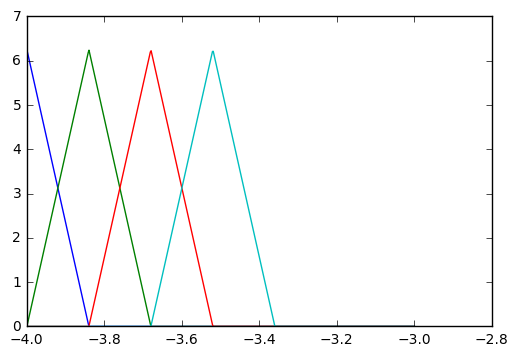

In [33]:
%matplotlib inline
x = np.linspace(-scaling,-scaling+1, 500)
plt.plot(x,phi(x,0))
plt.plot(x,phi(x,1))
plt.plot(x,phi(x,2))
plt.plot(x,phi(x,3))

# plt.plot(x,phi(x,iLevel//2 - 1))
# plt.plot(x,phi(x,iLevel//2))
# plt.plot(x,phi(x,iLevel//2 + 1))

# for j in np.arange(len(xweights)):
#     plt.plot(x,phi(x,j))

plt.show()

In [34]:
def G(x, y, h):
    fval = f(y)
    gval = np.abs(g(y))
    mu = y + fval*h
    sd = gval*np.sqrt(h)
    return scipy.stats.norm.pdf(x, loc=mu, scale=sd)

In [35]:
# after change of variables z = y - x
# def G2(x, z, h):
#     dg2h = 2.0*np.square(g(x + z))*h
#     # t1 is the normaliation constant
#     t1 = np.power(np.pi*dg2h,-0.5)
#     # numerator inside the exponential
#     numer = np.square(z + f(x + z)*h)
#     t2 = np.exp(-numer/dg2h)
#     return t1*t2

In [36]:
bmat = np.zeros((len(xweights),len(xweights)))
for i in np.arange(len(aPoints)):
    for k in np.arange(len(aPoints)):
        thisG = G(collocgrid[i],collocgrid[i]+xgrid,h).flatten()
        # thisG = G2(collocgrid[i],xgrid,h).flatten()
        bmat[i,k] = np.sum(xweights*thisG*phi(collocgrid[i]+xgrid,k))


In [37]:
# display condition number
print(np.linalg.cond(amat,p=2))
# print(np.linalg.cond(bmat,p=2))

# store psuedoinverse
amatinvbmat = np.linalg.solve(amat,bmat)

# enforce normalization
for i in np.arange(len(xweights)):
    amatinvbmat[:,i] = amatinvbmat[:,i]/np.sum(amatinvbmat[:,i])


1.0


In [38]:
c1 = np.linalg.solve(amat, p(collocgrid))
# print(np.sum(c1))
# c2 = np.matmul(amatinvbmat,c1).flatten()
# print(np.sum(c2))
# print(np.sum(amatinvbmat,axis=0))

In [39]:
cvec = c1
for i in np.arange(numsteps-1):
    cvec = np.matmul(amatinvbmat,cvec).flatten()

finalpdf = np.matmul(amat,cvec)
exactsol = exactpdf(collocgrid,ft)

In [40]:
print(np.sum(cvec))

1.00000000601


In [41]:
np.linalg.norm(finalpdf - exactsol)/len(xgrid)

0.0022618148350861513

In [42]:
np.dot(xweights, exactpdf(xgrid,ft))

1.0000000019242923

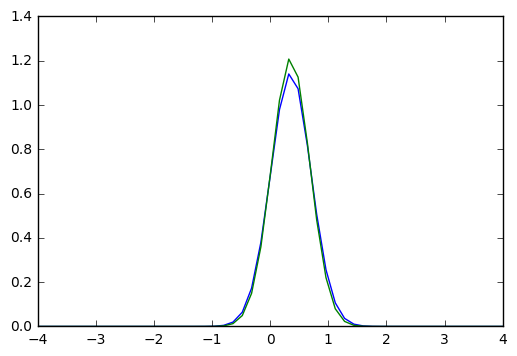

In [43]:
%matplotlib inline
plt.plot(collocgrid, finalpdf)
plt.plot(collocgrid, exactsol)
plt.show()
